In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Load classification model

In [10]:
classification_model = tf.keras.models.load_model('TrainedModel/trainedModel.h5')

# Load dataset
### And convert it to numpy array

In [2]:
train_X = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainX13.csv', header=None)
train_Y = pd.read_csv('/home/ege/Repo/SideChannel-AdversarialAI/Tensorflow/DataSet/trainY13.csv', header=None)

trainY = train_Y.to_numpy()
trainX = train_X.to_numpy()
trainX = np.expand_dims(trainX,axis=2)

# Normalize dataset

In [3]:
minimum = np.amin(trainX)
maximum = np.amax(trainX)

trainX_normalized = (trainX-minimum)/(maximum-minimum)

#Uncomment below if you need to fit with a dataset for specific class

#classToCut = 6

#trainXCUT = trainX[classToCut::14]
#trainYCUT = trainY[classToCut::14]

# Define Sampling layer as a subclass of keras.layers.Layer
## Sampling layer: Layer that samples a random point in latent space from a distribution with a mean and variance

In [4]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Define latent space dimension

In [5]:
latent_dim = 2

# Encoder

In [6]:

encoder_inputs = keras.Input(shape=(6000,1))

x = layers.Conv1D(256,16,strides=2,padding='same',activation='relu')(encoder_inputs)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

x = layers.Conv1D(128,16,strides=2,padding='same',activation='relu')(x)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

x = layers.Conv1D(64,8,strides=2,padding='same',activation='relu')(x)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

x = layers.Conv1D(32,8,strides=2,padding='same',activation='relu')(x)#possibly update kernel_initializer
#x = layers.MaxPooling1D(pool_size = 4,strides = 4, padding = 'same')(x)

shape_before_flattening = K.int_shape(x)

flatten_1 = layers.Flatten()(x)

#x = layers.LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,kernel_initializer='VarianceScaling',recurrent_initializer = 'orthogonal',bias_initializer='Zeros', return_sequences = True)(flatten_1) #Variance Scaling


x = layers.Dense(64 , activation="relu")(flatten_1)
x = layers.Dense(32 , activation="relu")(x)
x = layers.Dense(16 , activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean",kernel_initializer='Zeros',bias_initializer = 'Zeros')(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var",kernel_initializer='Zeros',bias_initializer = 'Zeros')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 3000, 256)    4352        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1500, 128)    524416      ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 750, 64)      65600       ['conv1d_1[0][0]']               
                                                                                            

2022-03-18 20:01:17.751747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-18 20:01:18.538340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22306 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


# Decoder

In [7]:

#DECODER
latent_inputs = keras.Input(shape=(latent_dim,))


x = layers.Dense(16 , activation="relu")(latent_inputs)
x = layers.Dense(32 , activation="relu")(x)
x = layers.Dense(64 , activation="relu")(x)

#x = layers.LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,kernel_initializer='VarianceScaling',recurrent_initializer = 'orthogonal',bias_initializer='Zeros', return_sequences = True)(x) #Variance Scaling


x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(x)
x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv1DTranspose(32, 8, activation="relu", strides=2,padding='same')(x)
x = layers.Conv1DTranspose(64, 8, activation="relu", strides=2,padding='same')(x)
x = layers.Conv1DTranspose(128, 16, activation="relu", strides=2,padding='same')(x)
x = layers.Conv1DTranspose(256, 16, activation="relu", strides=2,padding='same')(x)


decoder_outputs = layers.Conv1DTranspose(1, 16, padding="same",activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                48        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 12000)             780000    
                                                                 
 reshape (Reshape)           (None, 375, 32)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 750, 32)          8224

# Defining subclass VAE
## VAE is a subclass of keras.Model class

In [8]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),axis=(1)
                )
            )
            kl_loss = -1 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=0))
            total_loss = reconstruction_loss + kl_loss
            #total_loss = reconstruction_loss #ABSOLUTELY CHANGE!
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train model

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(trainX_normalized, epochs=25, batch_size=128)

Epoch 1/25


2022-03-18 20:01:21.983688: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-03-18 20:01:24.681970: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 8s 135ms/step - loss: 3532.7563 - reconstruction_loss: 3004.9863 - kl_loss: 0.0162
Epoch 2/25
14/14 [==============================] - 2s 120ms/step - loss: 2322.7481 - reconstruction_loss: 2254.4863 - kl_loss: 1.2359e-04
Epoch 3/25
14/14 [==============================] - 2s 120ms/step - loss: 2241.4622 - reconstruction_loss: 2208.2051 - kl_loss: 0.0203
Epoch 4/25
14/14 [==============================] - 2s 120ms/step - loss: 2222.5891 - reconstruction_loss: 2192.5100 - kl_loss: 0.2005
Epoch 5/25
14/14 [==============================] - 2s 121ms/step - loss: 2191.3831 - reconstruction_loss: 2184.2324 - kl_loss: 0.6270
Epoch 6/25
14/14 [==============================] - 2s 122ms/step - loss: 2191.2850 - reconstruction_loss: 2183.3777 - kl_loss: 1.1114
Epoch 7/25
14/14 [==============================] - 2s 121ms/step - loss: 2215.3687 - reconstruction_loss: 2190.1438 - kl_loss: 2.1530
Epoch 8/25
14/14 [==============================] - 2s 122ms/s

# Test reconstructed dataset with the classification model

### Predict reconstructed dataset

In [11]:
sumOfAccuracy = 0

for j in range(14):
    classPrediction = j
    trainXCUT = trainX_normalized[classPrediction::14]

    z_mean, z_log_var, z = vae.encoder.predict(trainXCUT)
    reconstructed_x = vae.decoder.predict(z)

    predictions = classification_model.predict(reconstructed_x)


    #print(predictions)
    correctPredAmt = 0
    for i, y_i in enumerate(predictions):
        firstHighest = np.argmax(y_i)
        y_i[firstHighest] = 0
        secondHighest = np.argmax(y_i)
        y_i[secondHighest] = 0
        thirdHighest = np.argmax(y_i)

        if(firstHighest == classPrediction or secondHighest == classPrediction or thirdHighest == classPrediction):
            correctPredAmt = correctPredAmt + 1

        #print(str(firstHighest) +", "+str(secondHighest)+", "+str(thirdHighest))
    
    accuracy = correctPredAmt/(len(predictions))
    sumOfAccuracy = sumOfAccuracy + accuracy
                               
    print("Class "+str(j)+": "+str(accuracy))

averageAccuracy = sumOfAccuracy/14
print("Average: "+ str(averageAccuracy))

Class 0: 0.0
Class 1: 0.4166666666666667
Class 2: 0.0
Class 3: 0.0
Class 4: 0.9083333333333333
Class 5: 0.3416666666666667
Class 6: 0.008333333333333333
Class 7: 0.0
Class 8: 0.875
Class 9: 0.0
Class 10: 0.0
Class 11: 0.7083333333333334
Class 12: 0.44166666666666665
Class 13: 0.0
Average: 0.2642857142857143


### Evaluate reconstructed dataset

In [12]:

for i in range(14):
    

    trainXCUT = trainX_normalized[i::14]
    trainYCUT = trainY[i::14]

    z_mean, z_log_var, z = vae.encoder.predict(trainXCUT)
    reconstructed_x = vae.decoder.predict(z)
    
    classification_model.evaluate(reconstructed_x,trainYCUT)
    

4/4 [==============================] - 0s 4ms/step - loss: 9.3342 - accuracy: 0.0000e+00


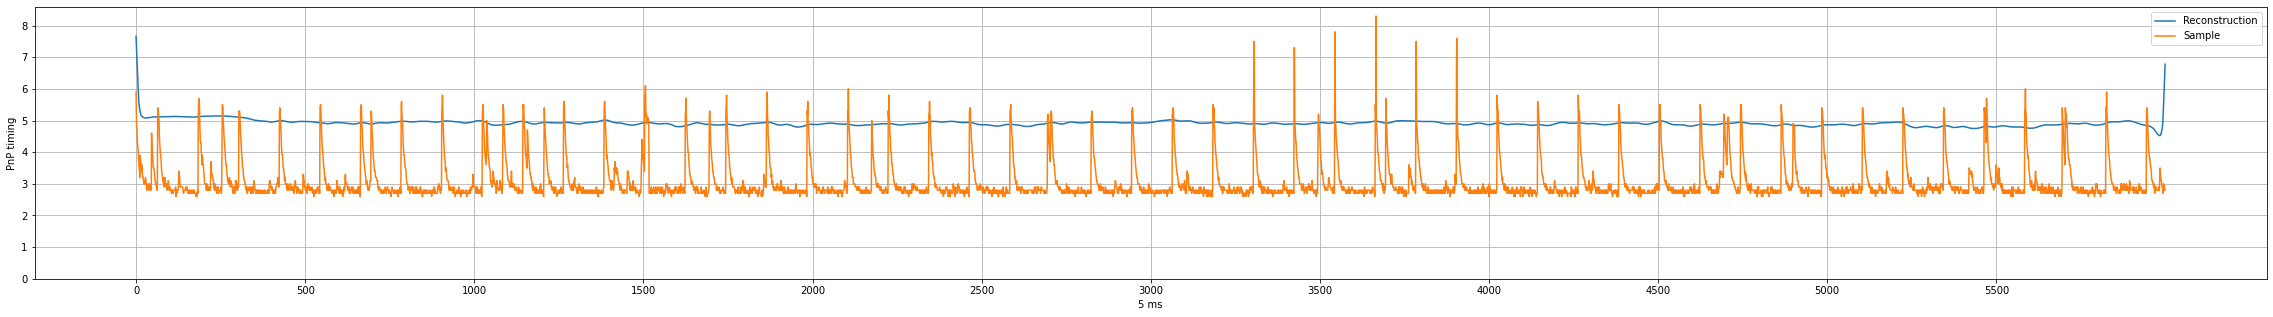

In [13]:

classToCut = 6
trainXCUT = trainX_normalized[classToCut::14]
trainYCUT = trainY[classToCut::14]

z_mean, z_log_var, z = vae.encoder.predict(trainXCUT)
reconstructed_x = vae.decoder.predict(z)*(maximum-minimum)+minimum

fig = plt.figure(figsize=(40,5))
#plt.plot(results)

sampleToPredict = 15

plt.plot(reconstructed_x[sampleToPredict],label='Reconstruction')
plt.plot(trainXCUT[sampleToPredict]*(maximum-minimum)+minimum,label='Sample')
#plt.plot(data3[0],label=3)
#plt.plot(data4[0],label=4)
#plt.plot(averageArray[0])

plt.legend()
plt.yticks(np.arange(0, 9, 1))
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
#plt.axhline(linewidth=1, color='r')
plt.xlabel("5 ms")
plt.ylabel("PnP timing")
#figure(figsize=(8, 6), dpi=80)
fig.savefig('vis_test.png',dpi=200)